In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_lowercase as abc

In [2]:
cmap=sns.color_palette("colorblind", as_cmap=True)
plt.style.use('seaborn-dark')

In [3]:
models = [
    pybamm.lithium_ion.SPM(),
    pybamm.lithium_ion.SPMe(),
    pybamm.lithium_ion.DFN()
]
param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)
c_rates = ['1C', '2C']
experiment1 = pybamm.Experiment(
    [
        "Discharge at " + c_rates[0] + " until 3.0 V",
    ],
    period="1 minute",
)
experiment2 = pybamm.Experiment(
    [
        "Discharge at " + c_rates[1] + " until 3.0 V",
    ],
    period="1 second",
)
solver = pybamm.CasadiSolver(mode="safe", dt_max=1)
sims = [[], []]
for lr, experiment in enumerate([experiment1, experiment2]):
    for model in models:
        sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment,
                                solver=solver)
        sim.solve(np.linspace(0, 1000, 101))
        sims[lr].append(sim)

2022-01-04 11:33:21,628 - [WARNING] simulation.solve(808): Ignoring t_eval as solution times are specified by the experiment
2022-01-04 11:33:22,441 - [WARNING] simulation.solve(808): Ignoring t_eval as solution times are specified by the experiment
2022-01-04 11:33:23,278 - [WARNING] simulation.solve(808): Ignoring t_eval as solution times are specified by the experiment
2022-01-04 11:33:24,650 - [WARNING] simulation.solve(808): Ignoring t_eval as solution times are specified by the experiment
2022-01-04 11:33:26,507 - [WARNING] simulation.solve(808): Ignoring t_eval as solution times are specified by the experiment
2022-01-04 11:33:28,466 - [WARNING] simulation.solve(808): Ignoring t_eval as solution times are specified by the experiment


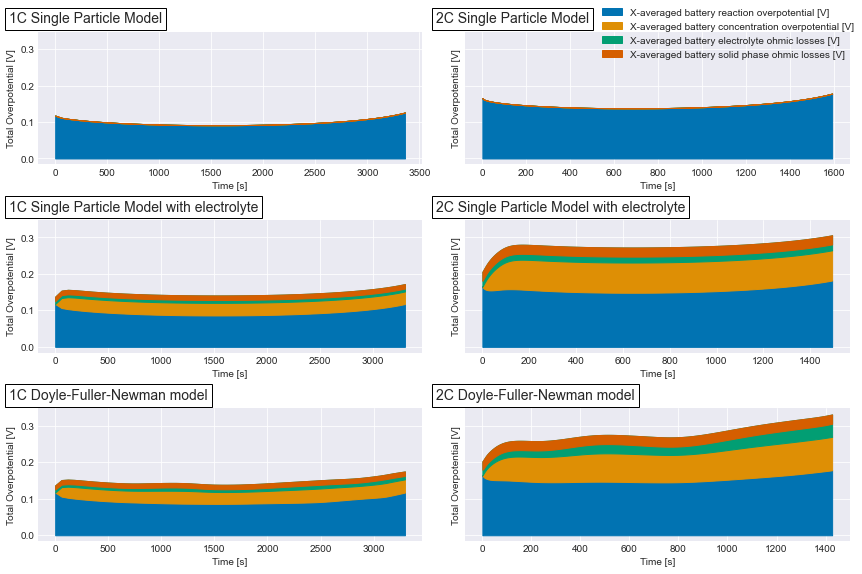

In [5]:
etas = [
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
]
nrow = 3
ncol = 2
fig, all_axes = plt.subplots(nrow, ncol, sharex=False, sharey=True, figsize=(12, 8))
all_axes = all_axes.T
try:
    cols = cmap(np.linspace(0.1, 0.9, 4))
except:
    cols = cmap
abc_counter = 0
for lr in range(2):
    col_sims = sims[lr]
    for ax, sim in enumerate(col_sims):
        axes = all_axes[lr]
        sol = sim.solution
        time = sol['Time [s]'].entries
        base = np.zeros_like(time)
        eta_r = -sol["X-averaged battery reaction overpotential [V]"].entries
        eta_c = -sol["X-averaged battery concentration overpotential [V]"].entries
        eta_e = -sol["X-averaged battery electrolyte ohmic losses [V]"].entries
        eta_s = sol["X-averaged battery solid phase ohmic losses [V]"].entries
        for si, source in enumerate([eta_r, eta_c, eta_e, eta_s]):
            axes[ax].fill_between(time, base, base+source, color=cols[si], label=etas[si])
            base += source
        axes[ax].set_xlabel('Time [s]')
        axes[ax].set_ylabel('Total Overpotential [V]')
        axes[ax].grid()
        t = axes[ax].text(-0.075, 1.15,
                          c_rates[lr] + ' ' +
                          sim.model.name, transform=axes[ax].transAxes,
                    fontsize=14, va='top')
        t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='black'))
        abc_counter += 1

handles, labels = axes[ax].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', )
plt.tight_layout()